# Environment Preparation

## Imports


In [1]:
#plot and handle
import pandas            as pd
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt
import matplotlib
import pickle

#display
from tabulate               import tabulate
from IPython.core.display   import HTML
from numerize import numerize as nm

#ML
from sklearn import neighbors     as nh
from sklearn import linear_model  as lm
from sklearn import ensemble      as en
from xgboost import XGBClassifier

## Path Handlers

In [2]:
datapath = '../data/'

## Helper Functions

In [3]:
def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['font.size'] = 20
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

def gain_lift_curve(yhat, yval, plot = True, size = (6,8), axvline="None"):
    '''
    plots gain and lift curve, respectively
    returns the curves and a table used to plot the curves
    '''

    # create table proba with the propensity score for each class (0 and 1)
    table_proba = pd.DataFrame(yhat)

    # add the 'response' column
    table_proba['target'] = yval.values

    # add the 'correct' column to evaluate wheter the prediction was right or not
    x = lambda x: "yes" if x[0] > x[1] and x['target'] == 0 else "yes" if x[1] > x[0] and x['target'] == 1 else "yes" if x[0] == x[1] else "no" 
    table_proba['correct'] = table_proba.apply(x, axis = 1)

    # order by propensity score for the class 1
    table_proba.sort_values(1, ascending = False, inplace = True)

    # create cumulative propensity score
    ## calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('target').count().loc[1,1]

    ## apply a score for every row which target is 1
    x = lambda x: 1/qty_class_1 if x['target'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create % cumulative of the base
    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    # create the lift column
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=size)

        # gap between graphics
        fig.tight_layout(pad =5)

        # gain curve
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_propensity_score'], label="cumulative (model)", linewidth = 2.5);
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_porc_base'], label="baseline", linewidth = 2.5, color = 'black' )
        axes[0].lines[1].set_linestyle("--")
        axes[0].legend()
        axes[0].set_title("cumulative gains curve")
        axes[0].set_xlabel("percentage of sample")
        axes[0].set_ylabel("gain")
        
        if axvline != "None":
            axes[0].axvline(axvline, 0, 1, color='green', ls='--', lw=2)
        
        # lift curve
        ## do not consider the beginning of the series, as it varies a lot (the sample is still small)
        table_proba_filtered = table_proba.query('cumulative_porc_base >= 0.1')

        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = table_proba_filtered['lift'], label="model", linewidth = 2.5 );
        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = np.ones(len(table_proba_filtered)), label="baseline", linewidth = 2.5, color = 'black' )
        axes[1].lines[1].set_linestyle("--")
        axes[1].legend()
        axes[1].set_title("lift curve")
        axes[1].set_xlabel("percentage of sample")

        if axvline != "None":
            axes[1].axvline(axvline, 0, 1, color='green', ls='--', lw=2)
        
        plt.show();
        
    return (table_proba)


def precision_recall_at_k(table, k=2000):
    ''' receives the dataset and returns: 
    - a tuple containg the precision at k and recall at k, respectively
    - a new table with precision_at_k and recall_at_k metrics '''
    # reset index
    table = table.reset_index (drop=True)
    # create ranking order
    table['ranking'] = table.index + 1 # as the index starts in 0 it is necessary to +1
    # calculate precision and recall
    table['precision_at_k'] = table['target'].cumsum() / table['ranking']
    table['recall_at_k'] = table['target'].cumsum() / table['target'].sum()

    return ((table.loc[k-1, 'precision_at_k'], table.loc[k-1, 'recall_at_k']),table)# as the loc uses index, it is necessAry to -1 to return the desired k


def compiled_precision_recall(list_of_dfs):
    dict_precision = {'Precision@': ['10% (3049)', '20% (6098)', '30% (9147)', '40% (12196)']}
    dict_recall = {'Recall@': ['10% (3049)', '20% (6098)', '30% (9147)', '40% (12196)']}
    
    for model in list_of_dfs:
        
        metrics10, _ = precision_recall_at_k(eval(model),3049)
        metrics20, _ = precision_recall_at_k(eval(model),6098)
        metrics30, _ = precision_recall_at_k(eval(model),9147)
        metrics40, _ = precision_recall_at_k(eval(model),12196)
        
        dict_precision[model] = [round(metrics10[0], 2),
                                 round(metrics20[0], 2),
                                 round(metrics30[0], 2), 
                                 round(metrics40[0], 2)]

        dict_recall[model] = [round(metrics10[1], 2), 
                              round(metrics20[1], 2),
                              round(metrics30[1], 2), 
                              round(metrics40[1], 2)]
        
    df_precision = pd.DataFrame(dict_precision).set_index('Precision@')
    df_recall = pd.DataFrame(dict_recall).set_index('Recall@')
    
    df_precision.columns = ['k-nearest neighbors',
                            'logistic regression',
                            'extra trees classifier',
                            'xgboost classifier',
                            'perfect model']
     
    df_recall.columns = ['k-nearest neighbors',
                            'logistic regression',
                            'extra trees classifier',
                            'xgboost classifier',
                            'perfect model' ]
    
    return (df_precision, df_recall)  

## Load Data

In [4]:
#train
x_train = pd.read_csv(datapath+'x_train.csv', index_col=0)
y_train = pd.read_csv(datapath+'y_train.csv', index_col=0)

#validation
x_val = pd.read_csv(datapath+'x_val.csv', index_col=0)
y_val = pd.read_csv(datapath+'y_val.csv', index_col=0)

# Machine Learning - Preliminary Analysis

Given the business problem, the objective of the project is to build an ordered list of purchase propensity (learning to rank problem), not to discover whether the customer will buy or not the insurance (traditional classification problem).

Some models will then be built, their performance will be compared, and we will analyze which one does this ranking task better.

Initially, a preliminary analysis with the models will be performed, and the unique performance of each model will be obtained.

Afterwards, a more detailed analysis with each model will be performed, through cross validation and hyperparameter tuning.

## KNN

In [5]:
# Model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )
# Model training
knn_model.fit( x_train, y_train.values.ravel() )
# Model prediction (proba)
yhat_proba_knn = knn_model.predict_proba( x_val );

## Logistic Regression


In [17]:
# Model definition
lr_model = lm.LogisticRegression( random_state=42 )
# Model training
lr_model.fit( x_train, y_train.values.ravel() )
# Model prediction (proba)
yhat_proba_lr = lr_model.predict_proba( x_val )

## Extra Trees


In [18]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=100, random_state=30, n_jobs=-1 )
# model training
et.fit ( x_train, y_train.values.ravel() )
# Model prediction (proba)
yhat_proba_et = et.predict_proba(x_val)

## XGBoost

In [19]:
xgb_model = xgb.XGBClassifier()

model_xgb = xgb_model.fit(x_train,y_train.values.ravel())

yhat_proba_xgb = model_xgb.predict_proba(x_val)

## Models Evaluation

Learning to Rank Evaluation Metrics:

For each model, a Cumulative Gain and Lift curve will be plotted:

- Cumulative Gain Curve: ordered by purchase probability, crosses the percentage of the customer base with the percentage of customers likely to buy.
     - Ex: 20% of the customer base (x), ordered by the purchase probability (y), contains 60% of all interested in vehicle insurance.

- Lift Curve: represents the difference between the gain curve and the random list. Therefore, it tells you how much better the model is compared to the random list.
     - Ex: By approaching 20% of the ordered list, the model is 2,5 times better than the random list.

For each model, Precision and recall at k will also be calculated:

- Precision at top k: counts how many predictions were correct up to k, and divides by all predictions made up to k.
 - Ex 1: Precision at top 10% (or 3049) k = 0.40 - It means that in 10% of the base, the model got 40% right compared to the perfect model, which would get 100% right at top 10%, being there are 12 % of total customers interested (no mistakes up to 12%).

 - Ex 2: Precision at top 40% (or 12196) k = 0.25 - It means that in 40% of the base, the model got 25% right compared to the perfect model,   which would get 60% right at top 40%, being that after 12%, it got them all right, and now it just goes downhill.


- Recall at top k: counts how many predictions were correct up to k, and divides by all true examples.
 - Ex: Recall at top 40% (or 12196) k = 0.8 - It means that 80% of the total interested customers appear in the top-40% results of the ordered list.

### KNN

#### Cumulative Gain and Lift Curve

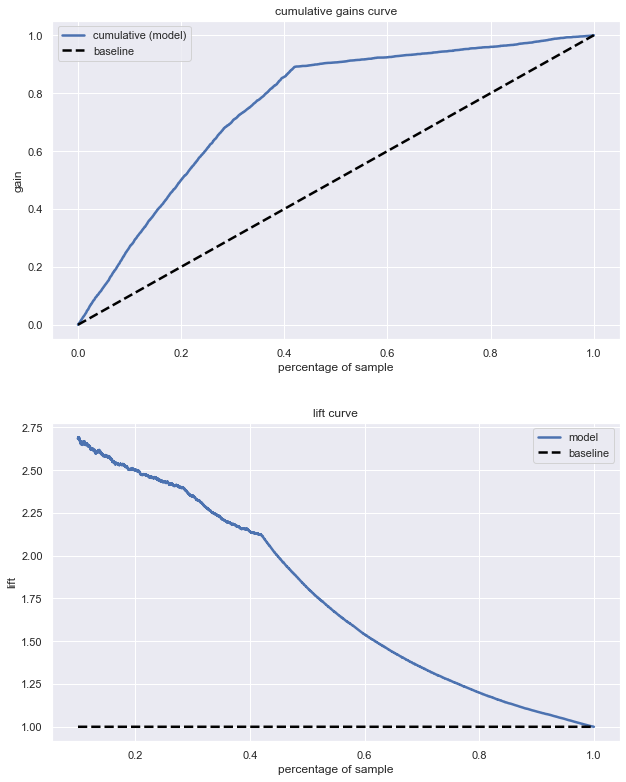

In [6]:
table_knn = gain_lift_curve(yhat_proba_knn, y_val, size = (10,12))

Gain: By approaching 40% of the ordered list, ~85% of all interested customers are reached.

Lift: By approaching 40% of the ordered list, the model performs ~2.2 times better than the random list.

In [21]:
#Could also be plotted with scikitplot library
#skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );   # Cumulative Gain
#skplt.metrics.plot_lift_curve(y_val, yhat_knn);          # Lift
    #The variation at the start of the lift curve is due to the still small sample during the table sweep for the graph construction. 

#### Precision@k and Recall@k

In [22]:
metrics_knn, new_table_knn = precision_recall_at_k(table_knn, 12200) #k = 12200 = 40% of customers

In [23]:
#full tabel knn
new_table_knn

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.0,1.0,0,no,0.000000,0.000000,0.000033,0.000000,1,0.000000,0.000000
1,0.0,1.0,0,no,0.000000,0.000000,0.000066,0.000000,2,0.000000,0.000000
2,0.0,1.0,1,yes,0.000268,0.000268,0.000098,2.719561,3,0.333333,0.000268
3,0.0,1.0,0,no,0.000000,0.000268,0.000131,2.039671,4,0.250000,0.000268
4,0.0,1.0,0,no,0.000000,0.000268,0.000164,1.631737,5,0.200000,0.000268
...,...,...,...,...,...,...,...,...,...,...,...
30484,1.0,0.0,0,yes,0.000000,1.000000,0.999869,1.000131,30485,0.122585,1.000000
30485,1.0,0.0,0,yes,0.000000,1.000000,0.999902,1.000098,30486,0.122581,1.000000
30486,1.0,0.0,0,yes,0.000000,1.000000,0.999934,1.000066,30487,0.122577,1.000000
30487,1.0,0.0,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122573,1.000000


In [24]:
#There are 3737 of 12200 rows with class 1 target feature, so the max precision that can be obtained is ~30% (3737/12200)
display(y_val.value_counts())

response
0           26752
1            3737
dtype: int64

In [25]:
print(f"KNN - \nPrecision at 40% of base(k): {round( metrics_knn[0] ,2)}\nRecall at 40% of base(k): {round( metrics_knn[1] ,2) }")

KNN - 
Precision at 40% of base(k): 0.26
Recall at 40% of base(k): 0.86


Precision at top 40% of base(k): It means that in 40% of the base, the model got 26% right compared to the perfect model, which would get ~60% right at top 40%, being that after 12%, it got them all right, and now it just goes downhill.

Recall at top 40% of base(k): It means that 86% of the total of interested customers appear in the top-40% results of the ordered list.

### Logistic Regression

#### Cumulative Gain and Lift Curve

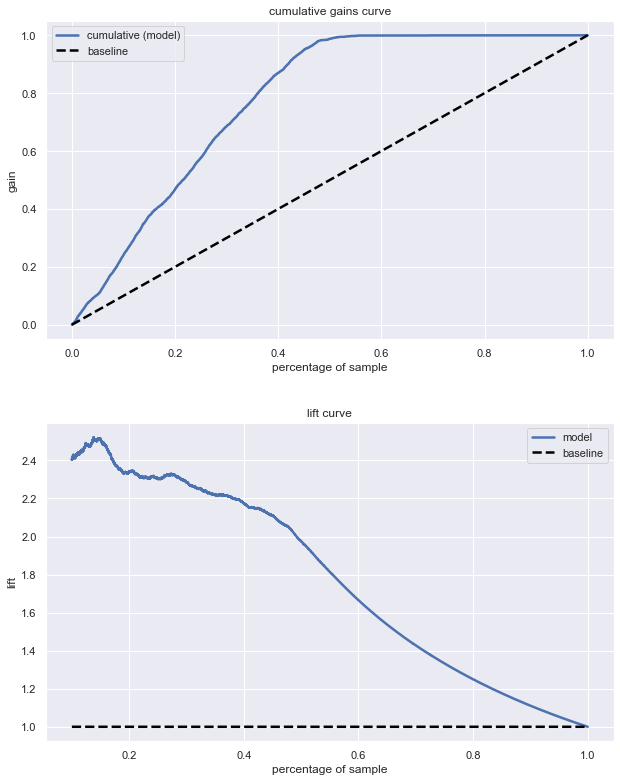

In [26]:
table_lr = gain_lift_curve(yhat_proba_lr, y_val, size = (10,12))

Gain: By approaching 40% of the ordered list, ~87% of all interested customers are reached.

Lift: By approaching 40% of the ordered list, the model performs ~2.1 times better than the random list.

#### Precision@k and Recall@k

In [27]:
metrics_lr, new_table_lr = precision_recall_at_k(table_lr, 12200) #k = 12200 = 40% of customers

In [28]:
#full tabel lr
new_table_lr

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.618703,0.381297,1,no,0.000268,0.000268,0.000033,8.158683,1,1.000000,0.000268
1,0.622390,0.377610,0,yes,0.000000,0.000268,0.000066,4.079342,2,0.500000,0.000268
2,0.653969,0.346031,0,yes,0.000000,0.000268,0.000098,2.719561,3,0.333333,0.000268
3,0.655189,0.344811,0,yes,0.000000,0.000268,0.000131,2.039671,4,0.250000,0.000268
4,0.655436,0.344564,0,yes,0.000000,0.000268,0.000164,1.631737,5,0.200000,0.000268
...,...,...,...,...,...,...,...,...,...,...,...
30484,0.999545,0.000455,0,yes,0.000000,1.000000,0.999869,1.000131,30485,0.122585,1.000000
30485,0.999546,0.000454,0,yes,0.000000,1.000000,0.999902,1.000098,30486,0.122581,1.000000
30486,0.999548,0.000452,0,yes,0.000000,1.000000,0.999934,1.000066,30487,0.122577,1.000000
30487,0.999551,0.000449,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122573,1.000000


In [29]:
#There are 3737 of 12200 rows with class 1 target feature, so the max precision that can be obtained is ~30% (3737/12200)
display(y_val.value_counts())

response
0           26752
1            3737
dtype: int64

In [30]:
print(f"Logistic Regression - \nPrecision at 40% of base(k): {round( metrics_lr[0] ,2)}\nRecall at 40% of base(k): {round( metrics_lr[1] ,2) }")

Logistic Regression - 
Precision at 40% of base(k): 0.27
Recall at 40% of base(k): 0.87


Precision at top 40% of base(k): It means that in 40% of the base, the model got 27% right compared to the perfect model, which would get ~60% right at top 40%, being that after 12%, it got them all right, and now it just goes downhill.

Recall at top 40% of base(k): It means that 87% of the total of interested customers appear in the top-40% results of the ordered list.

### Extra Trees

#### Cumulative Gain and Lift Curve

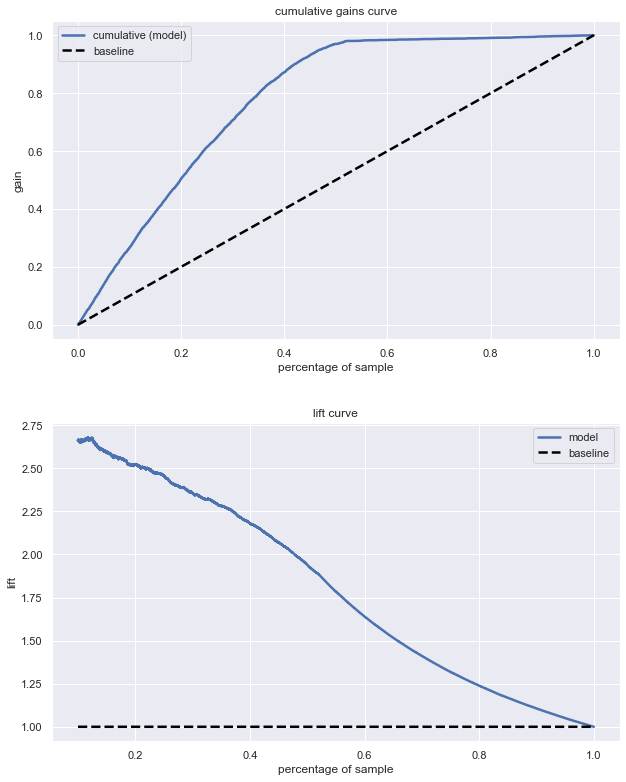

In [31]:
table_et = gain_lift_curve(yhat_proba_et, y_val, size = (10,12))

Gain: By approaching 40% of the ordered list, ~87% of all interested customers are reached.

Lift: By approaching 40% of the ordered list, the model performs ~2.2 times better than the random list.

#### Precision@k and Recall@k

In [32]:
metrics_et, new_table_et = precision_recall_at_k(table_et, 12200) #k = 12200 = 40% of customers

In [33]:
#full tabel et
new_table_et

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.0,1.0,0,no,0.000000,0.000000,0.000033,0.000000,1,0.000000,0.000000
1,0.0,1.0,0,no,0.000000,0.000000,0.000066,0.000000,2,0.000000,0.000000
2,0.0,1.0,1,yes,0.000268,0.000268,0.000098,2.719561,3,0.333333,0.000268
3,0.0,1.0,1,yes,0.000268,0.000535,0.000131,4.079342,4,0.500000,0.000535
4,0.0,1.0,0,no,0.000000,0.000535,0.000164,3.263473,5,0.400000,0.000535
...,...,...,...,...,...,...,...,...,...,...,...
30484,1.0,0.0,0,yes,0.000000,1.000000,0.999869,1.000131,30485,0.122585,1.000000
30485,1.0,0.0,0,yes,0.000000,1.000000,0.999902,1.000098,30486,0.122581,1.000000
30486,1.0,0.0,0,yes,0.000000,1.000000,0.999934,1.000066,30487,0.122577,1.000000
30487,1.0,0.0,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122573,1.000000


In [34]:
#There are 3737 of 12200 rows with class 1 target feature, so the max precision that can be obtained is ~30% (3737/12200)
display(y_val.value_counts())

response
0           26752
1            3737
dtype: int64

In [35]:
print(f"Extra Trees - \nPrecision at 40% of base(k): {round( metrics_et[0] ,2)}\nRecall at 40% of base(k): {round( metrics_et[1] ,2) }")

Extra Trees - 
Precision at 40% of base(k): 0.27
Recall at 40% of base(k): 0.87


Precision at top 40% of base(k): It means that in 40% of the base, the model got 27% right compared to the perfect model, which would get ~60% right at top 40%, being that after 12%, it got them all right, and now it just goes downhill.

Recall at top 40% of base(k): It means that 87% of the total of interested customers appear in the top-40% results of the ordered list.

### XGBoost

#### Cumulative Gain and Lift Curve

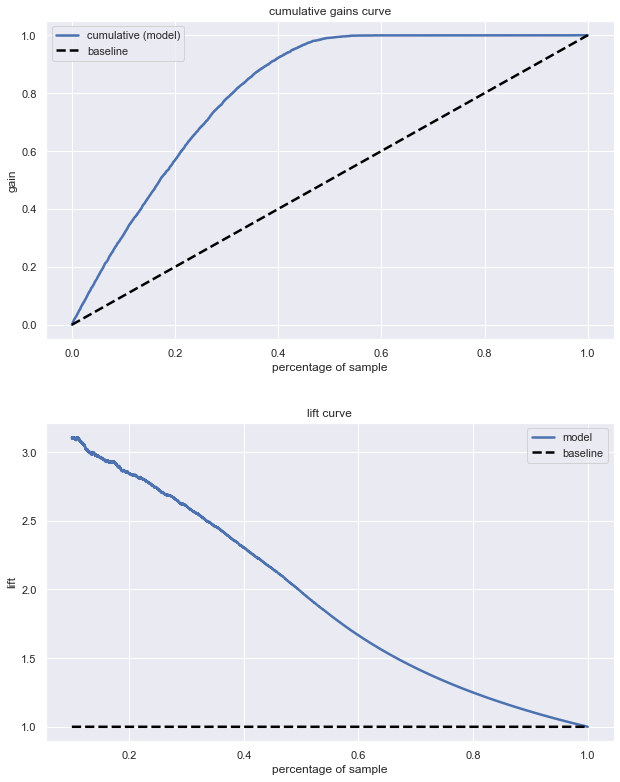

In [36]:
table_xgb = gain_lift_curve(yhat_proba_xgb, y_val, size = (10,12))

Gain: By approaching 40% of the ordered list, ~91% of all interested customers are reached.

Lift: By approaching 40% of the ordered list, the model performs ~2.3 times better than the random list.

#### Precision@k and Recall@k

In [37]:
metrics_xgb, new_table_xgb = precision_recall_at_k(table_xgb, 12200) #k = 12200 = 40% of customers

In [38]:
#full tabel XGB
new_table_xgb

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.576325,0.423675,0,yes,0.000000,0.000000,0.000033,0.000000,1,0.000000,0.000000
1,0.576325,0.423675,1,no,0.000268,0.000268,0.000066,4.079342,2,0.500000,0.000268
2,0.576325,0.423675,0,yes,0.000000,0.000268,0.000098,2.719561,3,0.333333,0.000268
3,0.576325,0.423675,0,yes,0.000000,0.000268,0.000131,2.039671,4,0.250000,0.000268
4,0.576325,0.423675,0,yes,0.000000,0.000268,0.000164,1.631737,5,0.200000,0.000268
...,...,...,...,...,...,...,...,...,...,...,...
30484,0.999614,0.000386,0,yes,0.000000,1.000000,0.999869,1.000131,30485,0.122585,1.000000
30485,0.999640,0.000360,0,yes,0.000000,1.000000,0.999902,1.000098,30486,0.122581,1.000000
30486,0.999640,0.000360,0,yes,0.000000,1.000000,0.999934,1.000066,30487,0.122577,1.000000
30487,0.999643,0.000357,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122573,1.000000


In [39]:
print(f"XGBoost - \nPrecision at 40% of base(k): {round( metrics_xgb[0] ,2)}\nRecall at 40% of base(k): {round( metrics_xgb[1] ,2) }")

XGBoost - 
Precision at 40% of base(k): 0.28
Recall at 40% of base(k): 0.92


Precision at top 40% of base(k): It means that in 40% of the base, the model got 28% right compared to the perfect model, which would get ~60% right at top 40%, being that after 12%, it got them all right, and now it just goes downhill.

Recall at top 40% of base(k): It means that 92% of the total of interested customers appear in the top-40% results of the ordered list.

### Models Single Performance

Based on this preliminary analysis, the single performance of each model is compared in the table bellow.

Consider k=40% of base.

In [40]:
#Single Performance Table (#k=40% of base)
prec_at_k_knn, recall_at_k_knn = metrics_knn
prec_at_k_lr, recall_at_k_lr = metrics_lr
prec_at_k_et, recall_at_k_et = metrics_et
prec_at_k_xgb, recall_at_k_xgb = metrics_xgb

dict_sing_perf = {
    'model': ['KNN', 'Logistic Regression', 'Extra Trees', 'XGBoost'],
    'precision_at_k': [prec_at_k_knn, prec_at_k_lr, prec_at_k_et, prec_at_k_xgb],
    'recall_at_k': [recall_at_k_knn, recall_at_k_lr, recall_at_k_et, recall_at_k_xgb]
}

df_single_perf = pd.DataFrame(dict_sing_perf)
df_single_perf

,model,precision_at_k,recall_at_k
0,KNN,0.262295,0.856302
1,Logistic Regression,0.266557,0.870217
2,Extra Trees,0.267131,0.872090
3,XGBoost,0.282459,0.922130


We got a single performance, but two things are missing here:

- 1) Fair sampling: the way we did it, we run the risk of getting a good sample of the data, due to selection bias. This will be resolved with cross-validation.
- 2) Select the best hyperparameters for each model. This will be resolved with hyperparameter fine tuning.

A detailed analysis of the models will be carried out below, contemplating this.

# Machine Learning - Detailed analysis

In this section, a detailed analysis of each model will be performed in a specific file.

In each file, the hyperparameter fine tuning will be performed, which aims to identify the best set of parameters for each model, in order to maximize its learning capacity.

We will use the Random Search technique, where possible values ​​are predefined for each hyperparameter, and several models will be run, selecting a set of parameters at random.

For each model run, a cross-validation is applied that makes 10 cuts in the data space, in order to reduce data selection bias (sampling theory).

The data will then be tabulated to identify the model with the best results. A final version of the model will be run, with the best hyperparameters, and its cumulative gain curve, lift, precision at k and recall at k will be generated.

The data will then be exported so that the model results can be compared in the following section.

## Models Evaluation

Here, the results of the best models, which were run in separate files, will be compared.

For this, a cumulative gain curve and a lift curve will be generated, as well as the precision at k and recall at k of each model will also be generated below.

### Load model's ranked list and test data

In [411]:
# load model's ranked list
df_knn = pd.read_pickle(datapath+'processed/knn_table.pkl')
df_lr =  pd.read_pickle(datapath+'processed/lr_table.pkl')
df_et =  pd.read_pickle(datapath+'processed/et_table.pkl')
df_xgb = pd.read_pickle(datapath+'processed/xgb_table.pkl')
df_perfect_model =  pd.read_pickle(datapath+'processed/perfect_model_table.pkl')

# load test
x_test = pd.read_csv(datapath+'x_test.csv', index_col=0)
y_test = pd.read_csv(datapath+'y_test.csv', index_col=0)

cols_selected = ['days_associated','health_annual_paid','age','region_code',
                 'vehicle_damage','policy_sales_channel', 'vehicle_prev_insured']

#to make this section independent of the previous ones (only depending on the imports), just import training data here.

### Cumulative gains curves

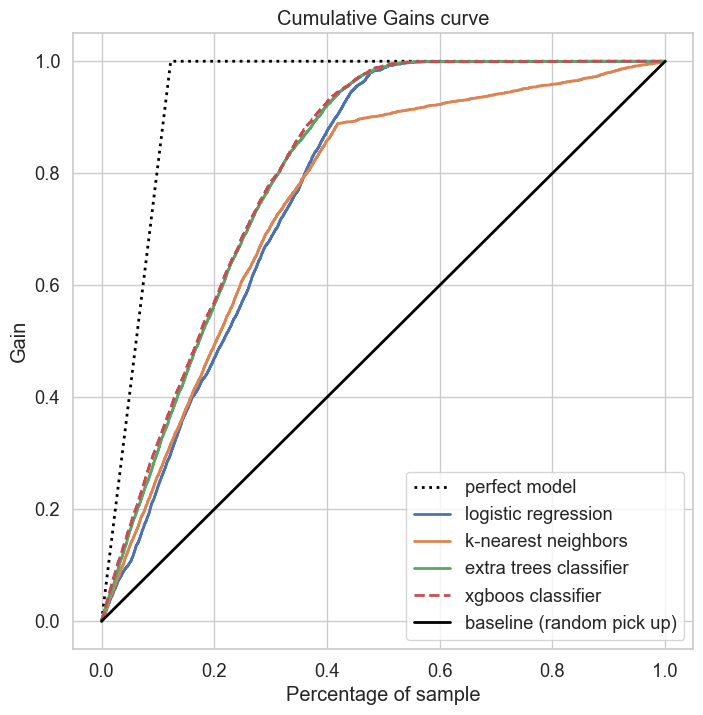

In [412]:
# restore to default matplotlib and seaborn configuration
matplotlib.rc_file_defaults()
sns.reset_orig
sns.set_theme(font_scale = 1.2, style = 'whitegrid')

# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# plot the graphics
sns.lineplot(ax = axes, x = df_perfect_model['cumulative_porc_base'], y = df_perfect_model['cumulative_propensity_score'], label="perfect model", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = df_lr['cumulative_porc_base'], y = df_lr['cumulative_propensity_score'], label="logistic regression", linewidth = 2)
sns.lineplot(ax = axes, x = df_knn['cumulative_porc_base'], y = df_knn['cumulative_propensity_score'], label="k-nearest neighbors ", linewidth = 2)
sns.lineplot(ax = axes, x = df_et['cumulative_porc_base'], y = df_et['cumulative_propensity_score'], label="extra trees classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_xgb['cumulative_porc_base'], y = df_xgb['cumulative_propensity_score'], label="xgboos classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_perfect_model['cumulative_porc_base'], y = df_perfect_model['cumulative_porc_base'], label="baseline (random pick up)", linewidth = 2, color = 'black')

axes.lines[0].set_linestyle(":")
axes.lines[4].set_linestyle("--")

axes.legend()
axes.set_title("Cumulative Gains curve")
axes.set_xlabel("Percentage of sample")
axes.set_ylabel("Gain")

axes.plot;

### Lift Curves

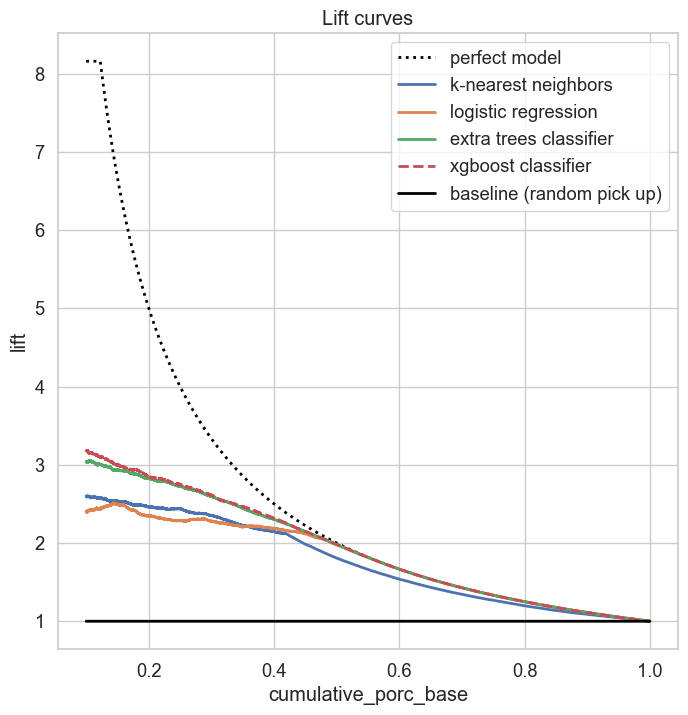

In [413]:
#sns.set()
sns.set_theme(font_scale = 1.2, style = 'whitegrid')

## do not consider the beginning of the series, as it varies a lot (the sample is still small)
df_knn_filtered = df_knn.query('cumulative_porc_base >= 0.1')
df_lr_filtered = df_lr.query('cumulative_porc_base >= 0.1')
df_et_filtered = df_et.query('cumulative_porc_base >= 0.1')
df_xgb_filtered = df_xgb.query('cumulative_porc_base >= 0.1')
df_perfect_model_filtered = df_perfect_model.query('cumulative_porc_base >= 0.1')

# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

sns.lineplot(ax = axes, x = df_perfect_model_filtered['cumulative_porc_base'], y = df_perfect_model_filtered['lift'], label="perfect model", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = df_knn_filtered['cumulative_porc_base'], y = df_knn_filtered['lift'], label="k-nearest neighbors ", linewidth = 2)
sns.lineplot(ax = axes, x = df_lr_filtered['cumulative_porc_base'], y = df_lr_filtered['lift'], label="logistic regression", linewidth = 2)
sns.lineplot(ax = axes, x = df_et_filtered['cumulative_porc_base'], y = df_et_filtered['lift'], label="extra trees classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_xgb_filtered['cumulative_porc_base'], y = df_xgb_filtered['lift'], label="xgboost classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_perfect_model_filtered['cumulative_porc_base'], y = np.ones(len(df_perfect_model_filtered)), label="baseline (random pick up)", linewidth = 2, color = 'black')

axes.lines[0].set_linestyle(":")
axes.lines[4].set_linestyle("--")

axes.legend()
axes.set_title("Lift curves")

axes.plot;

### Precision@k and recall@k

In [52]:
print(tabulate(compiled_precision_recall(['df_knn','df_lr','df_et','df_xgb','df_perfect_model'])[0], headers='keys', tablefmt='fancy_grid'))

╒══════════════╤═══════════════════════╤═══════════════════════╤══════════════════════════╤══════════════════════╤═════════════════╕
│ Precision@   │   k-nearest neighbors │   logistic regression │   extra trees classifier │   xgboost classifier │   perfect model │
╞══════════════╪═══════════════════════╪═══════════════════════╪══════════════════════════╪══════════════════════╪═════════════════╡
│ 10% (3049)   │                  0.32 │                  0.29 │                     0.37 │                 0.39 │            1    │
├──────────────┼───────────────────────┼───────────────────────┼──────────────────────────┼──────────────────────┼─────────────────┤
│ 20% (6098)   │                  0.3  │                  0.29 │                     0.35 │                 0.35 │            0.61 │
├──────────────┼───────────────────────┼───────────────────────┼──────────────────────────┼──────────────────────┼─────────────────┤
│ 30% (9147)   │                  0.29 │                  0.28 │     

In [53]:
print(tabulate(compiled_precision_recall(['df_knn','df_lr','df_et','df_xgb','df_perfect_model'])[1], headers='keys', tablefmt='fancy_grid'))

╒═════════════╤═══════════════════════╤═══════════════════════╤══════════════════════════╤══════════════════════╤═════════════════╕
│ Recall@     │   k-nearest neighbors │   logistic regression │   extra trees classifier │   xgboost classifier │   perfect model │
╞═════════════╪═══════════════════════╪═══════════════════════╪══════════════════════════╪══════════════════════╪═════════════════╡
│ 10% (3049)  │                  0.26 │                  0.24 │                     0.3  │                 0.32 │            0.82 │
├─────────────┼───────────────────────┼───────────────────────┼──────────────────────────┼──────────────────────┼─────────────────┤
│ 20% (6098)  │                  0.49 │                  0.47 │                     0.56 │                 0.57 │            1    │
├─────────────┼───────────────────────┼───────────────────────┼──────────────────────────┼──────────────────────┼─────────────────┤
│ 30% (9147)  │                  0.71 │                  0.68 │             

The model that presented the best performance in both precision and recall was the XGBoost Classifier. 

Let's subject the model now to never-before-seen test data.

## Model Test

In this section, let's train the XGBoost classifier with x_train and x_val datasets, and test using x_test dataset.

In this way, it will be possible to compare the performance of the model with training and validation data, and with test data.

It will then be possible to assess the model's generalizability, that is, the model's ability to rank never seen data.

In [57]:
# unify train and validation datasets
x_train = pd.concat([x_train, x_val])
y_train = pd.concat([y_train, y_val])


# model definition
xgbclassifier_model = XGBClassifier(n_estimators = 300,
                                    max_depth = 5,
                                    scale_pos_weight = 1,
                                    n_jobs= -1)

# model training
xgbclassifier_model.fit(x_train, y_train.values.ravel())

# model prediction (proba)
yhat_proba_xgb_final = xgbclassifier_model.predict_proba(x_test[cols_selected])

### Cumulative Gains and Lift Curves

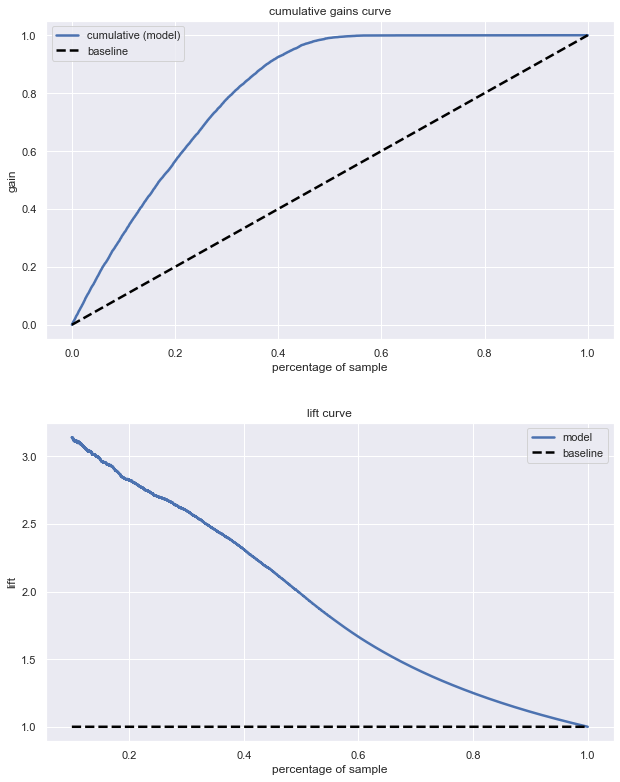

In [58]:
xgb_test = gain_lift_curve(yhat_proba_xgb_final, y_test, size = (10, 12))

### Precision@k and recall@k

In [59]:
# two dictionaies, one for each metric
dict_precision = {'Precision@': ['10%' , '20%', '30%', '40%']}
dict_recall = {'Recall@': ['10%', '20%', '30%', '40%']}

# metrics (precision@k and recall@k) for 10%, 20%, 30%, 40% of the ranked list resulting from train and validation datasets
metrics10_train, _ = precision_recall_at_k(df_xgb,3049)
metrics20_train, _ = precision_recall_at_k(df_xgb,6098)
metrics30_train, _ = precision_recall_at_k(df_xgb,9147)
metrics40_train, _ = precision_recall_at_k(df_xgb,12196)

# metrics (precision@k and recall@k) for 10%, 20%, 30%, 40% of the ranked list resulting from test dataset
metrics10_test, _ = precision_recall_at_k(xgb_test,7622)
metrics20_test, _ = precision_recall_at_k(xgb_test,15244)
metrics30_test, _ = precision_recall_at_k(xgb_test,22866)
metrics40_test, _ = precision_recall_at_k(xgb_test,30488)


# construction of the two dictionaries to include 2 columns, one for each dataset, and 4 rows, one for each percentage
# train and valdation
dict_precision['xgboost classifier (train)'] = [round(metrics10_train[0], 2),
                                                round(metrics20_train[0], 2),
                                                round(metrics30_train[0], 2), 
                                                round(metrics40_train[0], 2)]
# test
dict_precision['xgboost classifier (test)'] = [round(metrics10_test[0], 2),
                                               round(metrics20_test[0], 2),
                                               round(metrics30_test[0], 2), 
                                               round(metrics40_test[0], 2)]


# train and valdation
dict_recall['xgboost classifier (train)'] = [round(metrics10_train[1], 2),
                                                round(metrics20_train[1], 2),
                                                round(metrics30_train[1], 2), 
                                                round(metrics40_train[1], 2)]
# test
dict_recall['xgboost classifier (test)'] = [round(metrics10_test[1], 2),
                                               round(metrics20_test[1], 2),
                                               round(metrics30_test[1], 2), 
                                               round(metrics40_test[1], 2)]

# convert the dictionary to dataframe
df_precision = pd.DataFrame(dict_precision).set_index('Precision@')
df_recall = pd.DataFrame(dict_recall).set_index('Recall@')

In [61]:
print(tabulate(df_precision, headers='keys', tablefmt='fancy_grid'))

╒══════════════╤══════════════════════════════╤═════════════════════════════╕
│ Precision@   │   xgboost classifier (train) │   xgboost classifier (test) │
╞══════════════╪══════════════════════════════╪═════════════════════════════╡
│ 10%          │                         0.39 │                        0.38 │
├──────────────┼──────────────────────────────┼─────────────────────────────┤
│ 20%          │                         0.35 │                        0.35 │
├──────────────┼──────────────────────────────┼─────────────────────────────┤
│ 30%          │                         0.32 │                        0.32 │
├──────────────┼──────────────────────────────┼─────────────────────────────┤
│ 40%          │                         0.28 │                        0.28 │
╘══════════════╧══════════════════════════════╧═════════════════════════════╛


In [62]:
print(tabulate(df_recall, headers='keys', tablefmt='fancy_grid'))

╒═══════════╤══════════════════════════════╤═════════════════════════════╕
│ Recall@   │   xgboost classifier (train) │   xgboost classifier (test) │
╞═══════════╪══════════════════════════════╪═════════════════════════════╡
│ 10%       │                         0.32 │                        0.31 │
├───────────┼──────────────────────────────┼─────────────────────────────┤
│ 20%       │                         0.57 │                        0.56 │
├───────────┼──────────────────────────────┼─────────────────────────────┤
│ 30%       │                         0.78 │                        0.78 │
├───────────┼──────────────────────────────┼─────────────────────────────┤
│ 40%       │                         0.93 │                        0.92 │
╘═══════════╧══════════════════════════════╧═════════════════════════════╛


We observed that the model performed very similarly both using training and validation data and using test data (not previously used).

The generalization capability is therefore quite satisfactory, and the model is able to rank never-before-seen data effectively.

Therefore, the XGBoost model will be implemented in production.

In [89]:
# save production model
pickle.dump(xgbclassifier_model, open('../src/models/xgbclassifier_model.pkl', 'wb'))

# Business and Financial Results

In this section, estimates of operational and financial gains with the implementation of the final model in production will be demonstrated. 

## What percentage of customers interested in purchasing vehicle insurance will the sales team be able to contact by making 20,000 calls?

In [398]:
data = x_test.copy()
data['target'] = y_test.copy()
data['response'] = yhat_proba_xgb_final[:, 1].tolist()
data = data.sort_values('response', ascending=False)

In [399]:
percent_at_20k = 20000 / len(data)
recall_at_20k, table_20k = precision_recall_at_k(data, k=20000)

print(percent_at_20k)
print(recall_at_20k[1])

0.26239832065074786
0.70406852248394


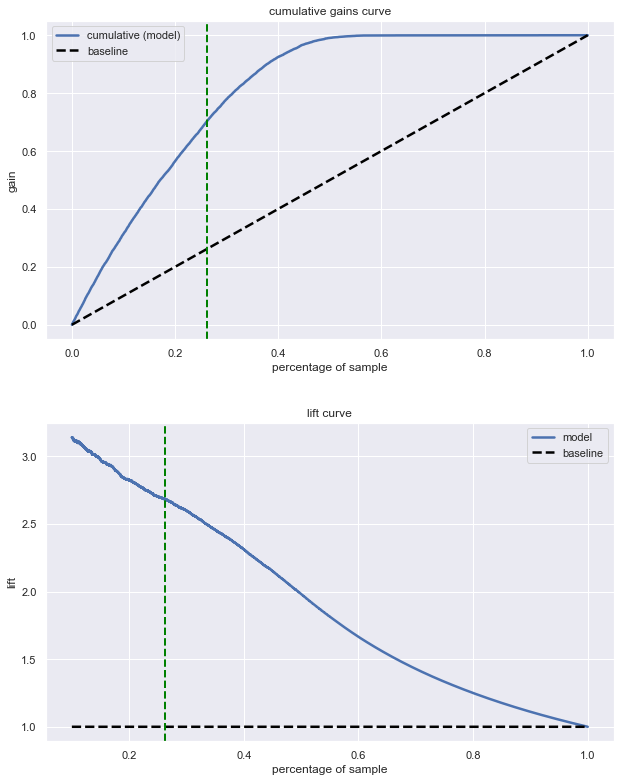

In [400]:
curves_at_20k = gain_lift_curve(yhat_proba_xgb_final, y_test, size = (10, 12), axvline=percent_at_20k)

In [409]:
#Scenario with 20000 phone calls
df_fin = pd.read_csv(datapath+'df3_feature_engeneering_done.csv', index_col=0)

print (f"We have {data.shape[0]} new customers, of which {round(data.loc[data['target'] == 1].shape[0])} are interested in vehicle insurance. ({round(data.loc[data['target'] == 1].shape[0] / data.shape[0] *100 ,2) }% of total new customers)")

print (f"The average ticket for an annual health insurance from Insurance All is: ${round(df_fin['health_annual_paid'].median())}.")
print (f"\nAssuming that all customers interested in vehicle insurance will sign the contract, and that the average value of vehicle insurance will be the same as the health insurance is, we can estimate as invoicing scenarios:")

print (f"\n_______________________________ SCENARIO WITH 20000 PHONE CALLS _____________________________________________________________________________")
print (f"By random list:")
print (f" - The sales team contacts {round(20000 / data.shape[0]*100 )}% of those interested in car insurance: {round( (20000 / data.shape[0]*100 ) / 100 * (round(data.loc[data['target'] == 1].shape[0])) )} customers (see Gain: intersection black x green line).\n  ==>  Estimated revenue: 2451 * 31669 = ${nm.numerize(77620719)} per year.")       

print (f"\nBy sorted list (model):")
print (f" - The sales team contacts {round(recall_at_20k[1]*100)}% of those interested in car insurance: {round( recall_at_20k[1]*100  / 100 * (data.loc[data['target'] == 1].shape[0]) )} customers (see Gain: intersection blue x green line).\n  ==> Estimated revenue: {round( recall_at_20k[1]*100  / 100 * (data.loc[data['target'] == 1].shape[0]) )} * 31669 = ${nm.numerize(208255344)} per year.")

print (f"\nRESULT: The model is {round(208255344 / 77620719 ,2)} times better than the random list (see Lift: intersection blue x green line). \nSo, the estimated revenue is {round(208255344 / 77620719 ,2)} times higher than the random list: ${nm.numerize(208255344 - 77620719)}.")

We have 76220 new customers, of which 9340 are interested in vehicle insurance. (12.25% of total new customers)
The average ticket for an annual health insurance from Insurance All is: $31669.

Assuming that all customers interested in vehicle insurance will sign the contract, and that the average value of vehicle insurance will be the same as the health insurance is, we can estimate as invoicing scenarios:

_______________________________ SCENARIO WITH 20000 PHONE CALLS _____________________________________________________________________________
By random list:
 - The sales team contacts 26% of those interested in car insurance: 2451 customers (see Gain: intersection black x green line).
  ==>  Estimated revenue: 2451 * 31669 = $77.62M per year.

By sorted list (model):
 - The sales team contacts 70% of those interested in car insurance: 6576 customers (see Gain: intersection blue x green line).
  ==> Estimated revenue: 6576 * 31669 = $208.26M per year.

RESULT: The model is 2.68 tim

## And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing vehicle insurance will the sales team be able to contact?

In [402]:
percent_at_40k = 40000 / len(data)
recall_at_40k, table_40k = precision_recall_at_k(data, k=40000)

print(percent_at_40k)
print(recall_at_40k[1])

0.5247966413014957
0.9950749464668094


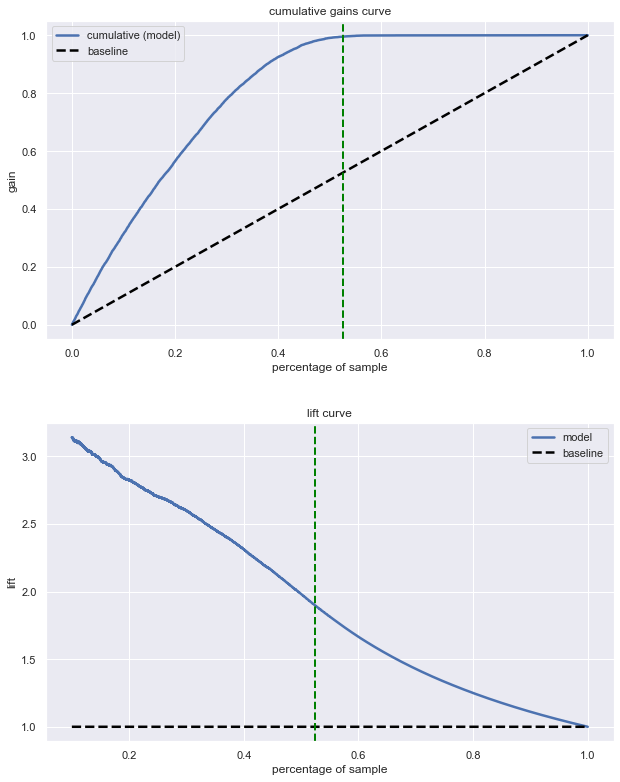

In [403]:
curves_at_40k = gain_lift_curve(yhat_proba_xgb_final, y_test, size = (10, 12), axvline=percent_at_40k)

In [414]:
#Scenario with 40000 phone calls
print (f"We have {data.shape[0]} new customers, of which {round(data.loc[data['target'] == 1].shape[0])} are interested in vehicle insurance. ({round(data.loc[data['target'] == 1].shape[0] / data.shape[0] *100 ,2) }% of total new customers)")
print (f"The average ticket for an annual health insurance from Insurance All is: ${round(df_fin['health_annual_paid'].median())}.")
print (f"\nAssuming that all customers interested in vehicle insurance will sign the contract, and that the average value of vehicle insurance will be the same as the health insurance is, we can estimate as invoicing scenarios:")

print (f"\n_______________________________ SCENARIO WITH 40000 PHONE CALLS_________________________________________________________________________")


print(f"By random list:")
print (f" - The sales team contacts {round(40000 / data.shape[0]*100 )}% of those interested in car insurance: {round( (40000 / data.shape[0]*100 ) / 100 * (round(data.loc[data['target'] == 1].shape[0])) )} customers (see Gain: intersection black x green line).\n ==> Estimated revenue = 4902 * 31669 = ${nm.numerize(155241438)} per year.")

print(f"\nBy sorted list (model): ")
print (f" - The sales team contacts {round(recall_at_40k[1]*100, 1)}% of those interested in car insurance: {round( recall_at_40k[1]*100 / 100 * (data.loc[data['target' ] == 1].shape[0]) )} customers (see Gain: intersection blue x green line).\n ==> Estimated revenue: 9291 * 31669 = ${nm.numerize(294236679)} per year.")

print(f"\nRESULT: The model is {round(294236679 / 155241438 ,2)} times better than the random list (see Lift: intersection blue x green line). \nSo the estimated revenue is {round(294236679 / 155241438 ,2)} times higher than the random list: ${nm.numerize(294236679 - 155241438)}." )

We have 76220 new customers, of which 9340 are interested in vehicle insurance. (12.25% of total new customers)
The average ticket for an annual health insurance from Insurance All is: $31669.

Assuming that all customers interested in vehicle insurance will sign the contract, and that the average value of vehicle insurance will be the same as the health insurance is, we can estimate as invoicing scenarios:

_______________________________ SCENARIO WITH 40000 PHONE CALLS_________________________________________________________________________
By random list:
 - The sales team contacts 52% of those interested in car insurance: 4902 customers (see Gain: intersection black x green line).
 ==> Estimated revenue = 4902 * 31669 = $155.24M per year.

By sorted list (model): 
 - The sales team contacts 99.5% of those interested in car insurance: 9294 customers (see Gain: intersection blue x green line).
 ==> Estimated revenue: 9291 * 31669 = $294.24M per year.

RESULT: The model is 1.9 times b

## How many calls does the sales team need to make to contact 80% of customers interested in purchasing vehicle insurance?

In [80]:
percent_at_23k = 23800 / len(data)
recall_at_23k, table_23k = precision_recall_at_k(data, k=23800)

print(percent_at_23k)
print(recall_at_23k[1])

0.31225400157438993
0.8007494646680943


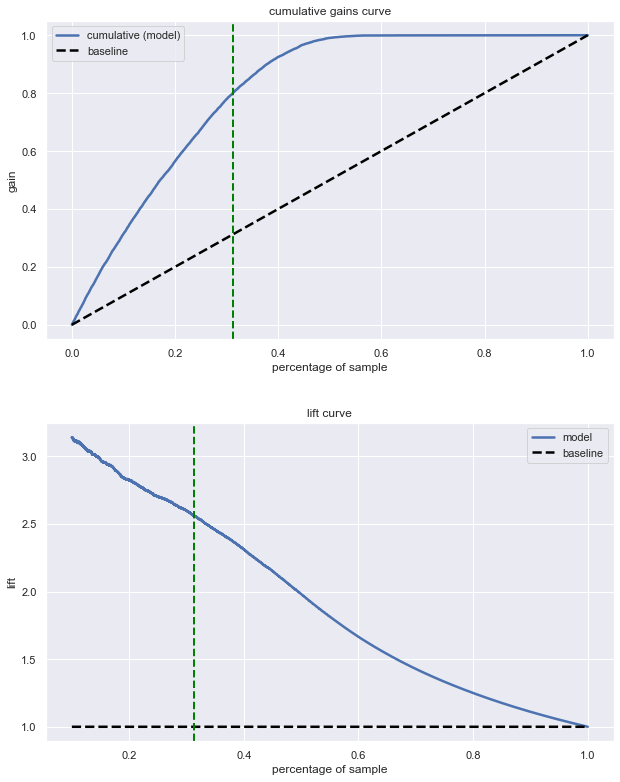

In [81]:
curves_at_23k = gain_lift_curve(yhat_proba_xgb_final, y_test, size = (10, 12), axvline=percent_at_23k)

In [417]:
#Scenario with 80% of interested
print(f"_______________________________ SCENARIO WITH 80% OF INTERESTED CUSTOMERS _____________________________________________________________________________")

print(f"By random list:")
print(f" - The sales team needs to make {round(0.8 * 76220)} calls, to contact 80% of the customers on the list, then will reach 80% of those interested in car insurance.")

print(f"\nBy sorted list (model): ")
print(f" - The sales team needs to make 23800 calls, to contact {round(percent_at_23k*100)}% of customers on the list, then will reach {round(recall_at_23k[1]*100)}% of those interested in car insurance ( see Gain: intersection blue x green line).")

print(f"\nRESULT: Making 23800 calls, the model is {round(60976 / 23800,2)} times better than the random list. (see Lift: intersection blue x green line).")

_______________________________ SCENARIO WITH 80% OF INTERESTED CUSTOMERS _____________________________________________________________________________
By random list:
 - The sales team needs to make 60976 calls, to contact 80% of the customers on the list, then will reach 80% of those interested in car insurance.

By sorted list (model): 
 - The sales team needs to make 23800 calls, to contact 31% of customers on the list, then will reach 80% of those interested in car insurance ( see Gain: intersection blue x green line).

RESULT: Making 23800 calls, the model is 2.56 times better than the random list. (see Lift: intersection blue x green line).


# Deploy to Production

## Health Insurance Class

The following class was created to be the pipeline of the model in production.
It contains all the necessary steps to perform the prediction probabilities: data cleaning, feature engineering, data preparation and the prediction itself.

The solution was deployed on Heroku Cloud: 'https://health-insurance-ranking.herokuapp.com/predict'

In [229]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance( object ):
    def __init__ (self):

        #local API test needs abs home_path
        self.home_path=''
        self.health_annual_paid_scaler        = pickle.load( open( self.home_path + 'features/health_annual_paid_scaler.pkl', 'rb'))
        self.age_scaler                       = pickle.load( open( self.home_path + 'features/age_scaler.pkl', 'rb'))
        self.days_assoc_scaler                = pickle.load( open( self.home_path + 'features/days_assoc_scaler.pkl', 'rb'))
        self.gender_target_encoder            = pickle.load( open( self.home_path + 'features/gender_target_encoder.pkl', 'rb'))
        self.region_code_target_encoder       = pickle.load( open( self.home_path + 'features/region_code_target_encoder.pkl', 'rb'))
        self.policy_sales_freq_encoder        = pickle.load( open( self.home_path + 'features/policy_sales_freq_encoder.pkl', 'rb'))

        
    def data_cleaning(self, df1):

        # Rename Columns
        cols_new = ['id', 'gender', 'age', 'region_code','policy_sales_channel','driving_license',
                        'vehicle_age', 'vehicle_damage', 'vehicle_prev_insured', 'health_annual_paid', 'days_associated']

        df1.columns = cols_new

        return df1


    def feature_engineering (self, df2):

        # vehicle damage
        dict_vehicle_damage = {'Yes': 1, 'No': 0}
        df2['vehicle_damage'] = df2['vehicle_damage'].map(dict_vehicle_damage)

        # vehicle_age
        dict_vehicle_age = {'> 2 Years':'over_2_years', '1-2 Year':'between_1_2_years', '< 1 Year': 'below_1_year' }
        df2['vehicle_age'] = df2['vehicle_age'].map(dict_vehicle_age)

        return df2


    def data_preparation (self, df3):

        # transformations
        df3['health_annual_paid'] = self.health_annual_paid_scaler.transform( df3[['health_annual_paid']].values )
        df3['age'] = self.age_scaler.transform( df3[['age']].values )
        df3['days_associated'] = self.days_assoc_scaler.transform( df3[['days_associated']].values )
        #df3.loc[:,'gender'] = df3['gender'].map(self.gender_target_encoder) #was not selected
        df3.loc[:,'region_code'] = df3['region_code'].map(self.region_code_target_encoder)
        df3.loc[:,'policy_sales_channel'] = df3['policy_sales_channel'].map(self.policy_sales_freq_encoder)
        #vars 'vehicle_damage' and 'vehicle_prev_insured' didn't have trasnformations.

        # feature Selection
        cols_selected = ['days_associated','health_annual_paid','age','region_code',
                            'vehicle_damage','policy_sales_channel', 'vehicle_prev_insured']
        #cols 'id', 'gender', 'driving_license' and 'vehicle_age' were features not selected.

        return df3[cols_selected]


    def get_prediction( self, model, original_data, test_data ):

        #model prediction
        pred = model.predict_proba( test_data )

        #join prediction into original data and sort
        original_data['score'] = pred[:, 1].tolist()
        original_data = original_data.sort_values('score', ascending=False)

        return original_data.to_json( orient= 'records', date_format = 'iso' )

## API Handler

The following class is the API handler, which will consume the previously created class.

In [ ]:
import pickle
import os
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# load model in memory
model = pickle.load(open('models/xgbclassifier_model.pkl', 'rb'))

# initialize API
app = Flask(__name__)

# create endpoint
@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: #there is data
        if isinstance(test_json, dict): #unique row
            test_raw = pd.DataFrame(test_json, index = [0])
        else: # multiple rows
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())

        #needed cause test_raw will be overwritten on pipeline
        test_raw_original = test_raw.copy()

        # instantiate HealthInsurance class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw_original, df3)

        #returns a json
        return df_response

    else: #if empty:
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( host='0.0.0.0', port=port )

## Production API Tester

In [418]:
import requests
import json
import pandas as pd

# loading full test dataset with 76222 rows (simulating production)
df_test = pd.read_csv(datapath+'full_test_data.csv', index_col=0) #3 rows of data
df_test = df_test.drop('response', axis=1).copy() #remove "response"
#df_test = df_test.sample(10) #sample
df_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated
275163,275164,Female,24,41,152,1,< 1 Year,No,1,31696.0,62
228955,228956,Female,39,41,124,1,1-2 Year,Yes,0,34202.0,188
183986,183987,Female,25,39,152,1,< 1 Year,No,0,31140.0,200
272782,272783,Female,67,28,26,1,> 2 Years,Yes,0,2630.0,17
24900,24901,Male,23,46,152,1,< 1 Year,No,1,32159.0,149
...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27,33,152,1,< 1 Year,No,1,32955.0,23
18930,18931,Male,49,40,124,1,> 2 Years,Yes,0,2630.0,277
135229,135230,Male,24,27,152,1,< 1 Year,No,0,26595.0,277
105049,105050,Male,22,29,152,1,< 1 Year,No,1,42844.0,140


In [419]:
# API Call Prod
data = json.dumps(df_test.to_dict(orient = 'records'))
url = 'https://health-insurance-ranking.herokuapp.com/predict'
header = {'Content-type':'application/json'}

r = requests.post( url, data = data, headers = header )
print( 'Status Code {}'.format( r.status_code )) 

Status Code 200


In [420]:
df_prod_final = pd.DataFrame( r.json(), columns = r.json()[0].keys() )
df_prod_final

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,score
0,203921,Female,47,28,26,1,1-2 Year,Yes,0,107966.0,202,0.739441
1,103374,Male,32,25,124,1,1-2 Year,Yes,0,192034.0,206,0.701999
2,222367,Female,46,28,26,1,1-2 Year,Yes,0,108651.0,151,0.687008
3,222778,Female,47,41,26,1,1-2 Year,Yes,0,107003.0,143,0.679988
4,330217,Male,50,39,26,1,1-2 Year,Yes,0,109080.0,193,0.655628
...,...,...,...,...,...,...,...,...,...,...,...,...
76217,94277,Female,83,47,124,1,1-2 Year,No,1,30090.0,70,0.000044
76218,309547,Female,64,15,152,1,1-2 Year,No,1,27638.0,256,0.000044
76219,1245,Female,78,28,152,1,1-2 Year,No,1,45112.0,236,0.000044
76220,292777,Female,77,46,152,1,1-2 Year,No,1,22024.0,234,0.000040
